In [1]:
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt

train = pd.read_csv("prideNprejudice.csv",delimiter="\t")

In [2]:
train.head()


,sentences
0,"It is a truth universally acknowledged, that a..."
1,"""My dear Mr. Bennet,"" said his lady to him one..."
2,Bennet replied that he had not.
3,"""But it is,"" returned she; ""for Mrs. Long has ..."
4,Bennet made no answer.


In [3]:
import warnings
warnings.filterwarnings('ignore')

import bs4 as bs
import nltk
# nltk.download('all')
from nltk.tokenize import sent_tokenize # tokenizes sentences
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

eng_stopwords = stopwords.words('english')

In [4]:
from nltk.corpus import stopwords
from nltk.util import ngrams


ps = PorterStemmer()
wnl = WordNetLemmatizer()

def review_cleaner(review,lemmatize=True,stem=False):
    '''
    Clean and preprocess a review.

    1. Remove HTML tags
    2. Use regex to remove all special characters (only keep letters)
    3. Make strings to lower case and tokenize / word split reviews
    4. Remove English stopwords
    5. Rejoin to one string
    '''
    ps = PorterStemmer()
    wnl = WordNetLemmatizer()
    #1. Remove HTML tags
    review = bs.BeautifulSoup(review).text

    
    #2. Remove punctuation
    review = re.sub("[^a-zA-Z]", " ",review)
    
    #3. Tokenize into words (all lower case)
    review = review.lower().split()
    
    #4.Set stopwords
    eng_stopwords = set(stopwords.words("english"))

    clean_review=[]
    for word in review:
        if word not in eng_stopwords:
            if lemmatize is True:
                word=wnl.lemmatize(word)
            elif stem is True:
                if word == 'oed':
                    continue
                word=ps.stem(word)
            clean_review.append(word)
    return(clean_review)

In [5]:
clean_txt = []
for i in range(0,len(train['sentences'])):
    clean_txt.append(review_cleaner(train['sentences'][i]))

In [6]:
clean_txt[0]

['truth',
 'universally',
 'acknowledged',
 'single',
 'man',
 'possessionof',
 'good',
 'fortune',
 'must',
 'want',
 'wife',
 'however',
 'little',
 'known',
 'feeling',
 'view',
 'man',
 'may',
 'hisfirst',
 'entering',
 'neighbourhood',
 'truth',
 'well',
 'fixed',
 'mindsof',
 'surrounding',
 'family',
 'considered',
 'rightful',
 'propertyof',
 'one',
 'daughter']

In [62]:
sentences=clean_txt
# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # ignore all words with total frequency lower than this                       
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    

from gensim.models import word2vec

model = word2vec.Word2Vec(sentences, workers=num_workers, \
           size=num_features, min_count = min_word_count, \
            window = context,iter=20)


# save the model for later use. You can load it later using Word2Vec.load()
model.save("model_1")

In [63]:
vocab_tmp = list(model.wv.vocab)
print('Vocab length:',len(vocab_tmp))
vocab_tmp[0]

Vocab length: 234


'man'

In [64]:
from sklearn.metrics.pairwise import cosine_similarity


In [65]:
model.similarity('man','woman')

0.99617046114502972

In [66]:
model.similarity('see','visit')

0.99369943659369309

In [67]:
model.similarity('two','mother')

0.98998099855167609

In [68]:
model.most_similar(positive=['lady','woman'], negative=['man'])

[('collins', 0.9768012166023254),
 ('catherine', 0.9760928750038147),
 ('lucas', 0.9730533361434937),
 ('room', 0.9583531022071838),
 ('daughter', 0.9532002210617065),
 ('charlotte', 0.9510802030563354),
 ('house', 0.9508532881736755),
 ('two', 0.9486631751060486),
 ('seemed', 0.9485880136489868),
 ('rosings', 0.9476629495620728)]

In [69]:
model.most_similar(positive=['sir','man'], negative=['woman'])

[('lucas', 0.9303553104400635),
 ('william', 0.9261990189552307),
 ('collins', 0.890133261680603),
 ('lady', 0.8730971813201904),
 ('charlotte', 0.8653660416603088),
 ('daughter', 0.8579386472702026),
 ('young', 0.8567472100257874),
 ('le', 0.85390305519104),
 ('say', 0.8532811403274536),
 ('take', 0.8531085252761841)]

In [70]:
model.doesnt_match("man woman ok kill".split())

'man'

In [71]:
model.doesnt_match("think come like lucas".split())

'lucas'

In [72]:
model.most_similar("love")

[('regard', 0.9991554021835327),
 ('heart', 0.9991470575332642),
 ('ever', 0.9989364147186279),
 ('really', 0.9988886713981628),
 ('marriage', 0.9988623857498169),
 ('power', 0.9988265037536621),
 ('reason', 0.9987472295761108),
 ('want', 0.9986894130706787),
 ('character', 0.9986242055892944),
 ('much', 0.9986101388931274)]

In [73]:
model.most_similar("visit")

[('returned', 0.9991984367370605),
 ('meryton', 0.9987325668334961),
 ('family', 0.9987310171127319),
 ('week', 0.9987285137176514),
 ('till', 0.9987049102783203),
 ('began', 0.9986638426780701),
 ('return', 0.998303234577179),
 ('rosings', 0.9981467723846436),
 ('great', 0.9980743527412415),
 ('thought', 0.9980107545852661)]

In [74]:
X = model[vocab_tmp]
X[0].shape

(300,)

In [75]:
model.corpus_count

5370

In [76]:
model.wv.syn0.shape

(234, 300)

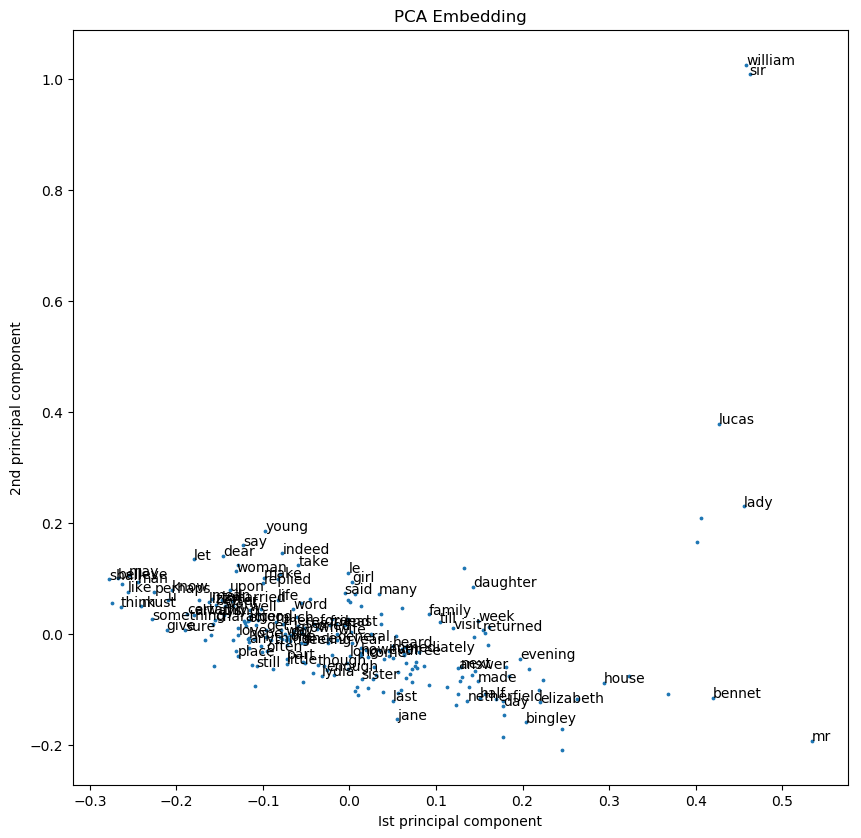

In [77]:
from sklearn import decomposition
# get two principle components of the feature space
pca= decomposition.PCA(n_components=2).fit_transform(model[vocab_tmp])

# set figure settings
plt.figure(figsize=(10,10),dpi=100)

# save pca values and vocab in dataframe df
df = pd.concat([pd.DataFrame(pca),pd.Series(vocab_tmp)],axis=1)
df.columns = ['x', 'y', 'word']



plt.xlabel("Ist principal component")
plt.ylabel('2nd principal component')


plt.scatter(x=pca[:, 0], y=pca[:, 1],s=3)
for i, word in enumerate(df['word'][0:100]):
    plt.annotate(word, (df['x'].iloc[i], df['y'].iloc[i]))
plt.title("PCA Embedding")
plt.show()

In [51]:
import sqlite3

In [62]:
connection = sqlite3.connect('company.db')
cursor = connection.cursor()
cursor.execute("DROP TABLE IF EXISTS parents;")

In [63]:
sql_command = """
CREATE TABLE parents (
parent VARCHAR(20),
child VARCHAR(20));"""
cursor.execute(sql_command)

In [64]:
sql_command = """
INSERT INTO parents (parent, child)
VALUES ("abraham", "barack") UNION
VALUES ("abraham", "clinton") UNION
VALUES ("delano", "herbert") UNION
VALUES ("fillmore", "abraham") UNION
VALUES ("fillmore", "delano") UNION
VALUES ("fillmore", "grover") UNION
VALUES ("eisenhower", "fillmore");"""
cursor.execute(sql_command)

In [65]:
connection.commit() 

connection.close()

In [67]:
connection = sqlite3.connect("company.db")

cursor = connection.cursor()

In [68]:
cursor.execute("SELECT * FROM parents") 

print("fetchall:") 

result = cursor.fetchall() 

for r in result:

    print(r)

fetchall:
('abraham', 'barack')
('abraham', 'clinton')
('delano', 'herbert')
('eisenhower', 'fillmore')
('fillmore', 'abraham')
('fillmore', 'delano')
('fillmore', 'grover')


In [69]:
sql_command = """
SELECT parent,child
FROM parents
WHERE parent = "abraham";"""
cursor.execute(sql_command)

print("fetching:") 

result = cursor.fetchall() 

for r in result:

    print(r)

fetching:
('abraham', 'barack')
('abraham', 'clinton')


In [71]:
sql_command = """
SELECT child
FROM parents
WHERE child LIKE '%e%';"""
cursor.execute(sql_command)

print("fetching:") 

result = cursor.fetchall() 

for r in result:

    print(r)

fetching:
('herbert',)
('fillmore',)
('delano',)
('grover',)


In [72]:
sql_command = """
SELECT DISTINCT parent
FROM parents
ORDER BY parent DESC;"""
cursor.execute(sql_command)

print("fetching:") 

result = cursor.fetchall() 

for r in result:

    print(r)

fetching:
('fillmore',)
('eisenhower',)
('delano',)
('abraham',)


In [100]:
sql_command = """
SELECT a.child, b.child
FROM parents a, parents b
WHERE a.parent=b.parent AND a.child > b.child;"""
cursor.execute(sql_command)

print("fetching:") 

result = cursor.fetchall() 

for r in result:

    print(r)

fetching:
('clinton', 'barack')
('delano', 'abraham')
('grover', 'abraham')
('grover', 'delano')


In [101]:
cursor.execute("DROP TABLE IF EXISTS dogs;")
sql_command = """
CREATE TABLE dogs AS
SELECT "abraham" AS name, "long" AS fur UNION
SELECT "barack", "short" UNION
SELECT "clinton", "long" UNION
SELECT "delano", "long" UNION
SELECT "eisenhower", "short" UNION
SELECT "fillmore", "curly" UNION
SELECT "grover", "short" UNION
SELECT "herbert", "curly";"""
cursor.execute(sql_command)

In [102]:
sql_command = """
SELECT count(*)
FROM dogs
WHERE fur ="short";"""
cursor.execute(sql_command)

print("fetching:") 

result = cursor.fetchall() 

for r in result:

    print(r)

fetching:
(3,)


In [109]:
sql_command = """
SELECT parents.parent
FROM parents INNER JOIN dogs ON parents.child =dogs.name AND dogs.fur ="curly";"""
cursor.execute(sql_command)

print("fetching:") 

result = cursor.fetchall() 

for r in result:

    print(r)

fetching:
('eisenhower',)
('delano',)


In [126]:
sql_command = """
SELECT a.child,b.child
FROM (parents INNER JOIN dogs ON parents.child =dogs.name) a, (parents INNER JOIN dogs ON parents.child =dogs.name) b
WHERE a.fur=b.fur AND b.parent=a.child;"""
cursor.execute(sql_command)

print("fetching:") 

result = cursor.fetchall() 

for r in result:

    print(r)

fetching:
('abraham', 'clinton')


In [127]:
cursor.execute("DROP TABLE IF EXISTS animals;")
sql_command = """
create table animals as
select "dog" as kind, 4 as legs, 20 as weight union
select "cat" , 4 , 10 union
select "ferret" , 4 , 10 union
select "parrot" , 2 , 6 union
select "penguin" , 2 , 10 union
select "t-rex" , 2 , 12000;"""
cursor.execute(sql_command)

In [128]:
sql_command = """
SELECT kind, MIN(weight)
FROM animals;"""
cursor.execute(sql_command)

print("fetching:") 

result = cursor.fetchall() 

for r in result:

    print(r)

fetching:
('parrot', 6)


In [129]:
sql_command = """
SELECT AVG(legs), AVG(weight)
FROM animals;"""
cursor.execute(sql_command)

print("fetching:") 

result = cursor.fetchall() 

for r in result:

    print(r)

fetching:
(3.0, 2009.3333333333333)


In [131]:
sql_command = """
SELECT a.kind, a.legs, a.weight
FROM animals a
WHERE a.legs > 2 AND a.weight <20;"""
cursor.execute(sql_command)

print("fetching:") 

result = cursor.fetchall() 

for r in result:

    print(r)

fetching:
('cat', 4, 10)
('ferret', 4, 10)


In [137]:
sql_command = """
SELECT legs, AVG(weight) as average_weights
FROM animals
GROUP BY legs;"""
cursor.execute(sql_command)

print("fetching:") 

result = cursor.fetchall() 

for r in result:

    print(r)

fetching:
(2, 4005.3333333333335)
(4, 13.333333333333334)
